## 1. Down load dataset

In [1]:
! curl -L https://github.com/towhee-io/examples/releases/download/data/reverse_image_search.zip -O
! unzip -q -o reverse_image_search.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  119M  100  119M    0     0  7870k      0  0:00:15  0:00:15 --:--:-- 11.3M:14 9507k


## 2. Create Milvus Collection And 

In [2]:
# Default Values
from glob import glob
# Towhee parameters
MODEL = 'vgg16'
DEVICE = None # if None, use default device (cuda is enabled if available)

# Milvus parameters
HOST = 'localhost'
PORT = '19530'
TOPK = 10
DIM = 512 # dimension of embedding extracted, change with MODEL
COLLECTION_NAME = 'image_net_search_engine'
INDEX_TYPE = 'IVF_FLAT'
METRIC_TYPE = 'L2'

# patterns of image paths
INSERT_SRC = './train/*/*.JPEG'
QUERY_SRC = './test/*/*.JPEG'

to_insert = glob(INSERT_SRC)
to_test = glob(QUERY_SRC)

### 2.1 Create helper functions

In [12]:
from towhee import pipe, ops, DataCollection
import numpy
from pathlib import Path
from pymilvus import connections, FieldSchema, CollectionSchema, DataType, Collection, utility

# Create Milvus collection (delete first if exists)
def create_milvus_collection(collection_name, dim):
    if utility.has_collection(collection_name):
        utility.drop_collection(collection_name)
    
    fields = [
        FieldSchema(name='path', dtype=DataType.VARCHAR, description='path to image', max_length=500, 
                    is_primary=True, auto_id=False),
        FieldSchema(name='embedding', dtype=DataType.FLOAT_VECTOR, description='image embedding vectors', dim=dim)
    ]
    schema = CollectionSchema(fields=fields, description='reverse image search')
    collection = Collection(name=collection_name, schema=schema)

    index_params = {
        'metric_type': METRIC_TYPE,
        'index_type': INDEX_TYPE,
        'params': {"nlist": 2048}
    }
    collection.create_index(field_name='embedding', index_params=index_params)
    return collection

# Read images
decoder = ops.image_decode('rgb').get_op()
def read_images(img_paths):
    imgs = []
    for p in img_paths:
        img = decoder(p)
        imgs.append(img)
#         imgs.append(Image(cv2.imread(p), 'RGB'))
    return imgs

# Get ground truth
def ground_truth(path):
    train_path = str(Path(path).parent).replace('test', 'train')
    return [str(Path(x).resolve()) for x in glob(train_path + '/*.JPEG')]

# Calculate Average Precision
def get_ap(pred: list, gt: list):
    ct = 0
    score = 0.
    for i, n in enumerate(pred):
        if n in gt:
            ct += 1
            score += (ct / (i + 1))
    if ct == 0:
        ap = 0
    else:
        ap = score / ct
    return ap

# Embedding pipeline
p_embed = (
    pipe.input('img_path')
        .map('img_path', 'img', ops.image_decode('rgb'))
        .map('img', 'vec', ops.image_embedding.timm(model_name=MODEL, device=DEVICE))
        .map('vec', 'vec', lambda x: x / numpy.linalg.norm(x, axis=0))
)

# yolo
def get_max_object(img, boxes):
    if len(boxes) == 0:
        return img
    max_area = 0
    for box in boxes:
        x1, y1, x2, y2 = box
        area = (x2-x1)*(y2-y1)
        if area > max_area:
            max_area = area
            max_img = img[y1:y2,x1:x2,:]
    return max_img

p_yolo = (
    pipe.input('img_path')
        .map('img_path', 'img', ops.image_decode('rgb'))
        .map('img', ('boxes', 'class', 'score'), ops.object_detection.yolov5())
        .map(('img', 'boxes'), 'object', get_max_object)
)

### 2.2 Create collection and Insert embeding data

In [9]:
connections.connect(host=HOST, port=PORT)

# Create collection
collection = create_milvus_collection(COLLECTION_NAME, DIM)
print(f'A new collection created: {COLLECTION_NAME}')

# Insert data
p_insert = (
        p_embed.map(('img_path', 'vec'), 'mr', ops.ann_insert.milvus_client(
                    host=HOST,
                    port=PORT,
                    collection_name=COLLECTION_NAME
                    ))
          .output('mr')
)

A new collection created: image_net_search_engine


In [10]:
for img_path in to_insert:
    p_insert(img_path)
print('Number of data inserted:', collection.num_entities)

Number of data inserted: 0


In [16]:
# We use this function to find similar image in backend
p_search_pre_yolo = (
    p_yolo.map('object', 'vec', ops.image_embedding.timm(model_name=MODEL, device=DEVICE))
          .map('vec', 'vec', lambda x: x / numpy.linalg.norm(x, axis=0))
          .map('vec', ('search_res'), ops.ann_search.milvus_client(
                host=HOST, port=PORT, limit=TOPK,
                collection_name=COLLECTION_NAME))
          .map('search_res', 'pred', lambda x: [str(Path(y[0]).resolve()) for y in x])
      #    .output('img_path', 'pred')
)
# DataCollection(p_search_pre_yolo('./test/rocking_chair/n04099969_23803.JPEG')).show()

Using cache found in /Users/nguyenbang/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-10-8 Python-3.9.18 torch-2.0.1 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


img,object,res,ap
,,,0.775

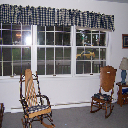
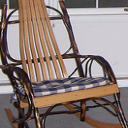
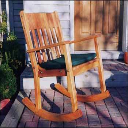
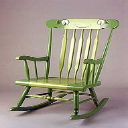
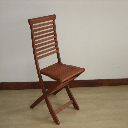
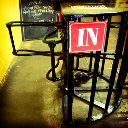
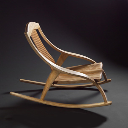
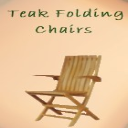
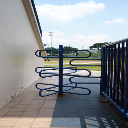
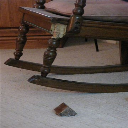
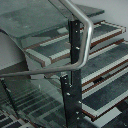
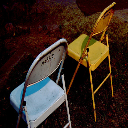

In [17]:
# Run this to test
p_search_img_yolo = (
    p_search_pre_yolo.map('img_path', 'gt', ground_truth)
                     .map(('pred', 'gt'), 'ap', get_ap)
                     .map('pred', 'res', read_images)
                     .output('img', 'object', 'res', 'ap')
)
DataCollection(p_search_img_yolo('./test/rocking_chair/n04099969_23803.JPEG')).show()